# DACON 컴퓨터 비전 학습 경진대회
### 2020.08.03 ~ 2020.09.14 17:59

## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import os


## Load Data
#### make data from .csv

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA(Exploratory Data Analysis, 탐색적 데이터 분석)
#### visualize data and find the feature

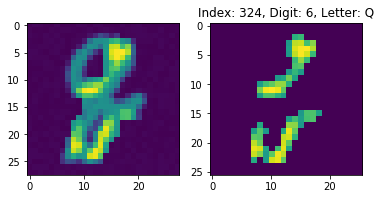

(26, 26)


In [17]:
idx = 324
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.subplot(121)
plt.imshow(img)

for n, i in enumerate(img):
    for m, j in enumerate(i):
        if img[n][m] < 10:
            img[n][m] = img[n][m]*0.1
            
        if img[n][m] < 135:
            img[n][m] = 0
        
img = np.delete(img, (0), axis=0)
img = np.delete(img, (-1), axis=0)
img = np.delete(img, (0), axis=1)
img = np.delete(img, (-1), axis=1)

plt.subplot(122)
plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

print(img.shape)

## Preprocessing
#### add feature image to the second channel of data.(data becomes (-1, 28, 28, 2))

In [22]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)

In [5]:
# This cell add feature channel(only digit pixels data) to the x_train. (x_train becomes (-1,28,28,2))

x_preprocessing = np.array(np.zeros(x_train.shape))

for p, img in enumerate(x_train):
    for q, i in enumerate(img):
        for r, j in enumerate(i):
            if img[q][r] < 135:
                x_preprocessing[p][q][r] = 0
                
x_train = np.concatenate((x_train, x_preprocessing), axis=3)

In [23]:
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

x_val = x_train[-int(len(x_train)*0.2):]
y_val = y_train[-int(len(y_train)*0.2):]
x_train = x_train[:-int(len(x_train)*0.2)]
y_train = y_train[:-int(len(y_train)*0.2)]

print(str(x_val.shape))
print(str(y_val.shape))
print(str(x_train.shape))
print(str(y_train.shape))

## Train model
#### using variation of baseline model
#### + add kernel_initializer='he_normal'
#### + add kernel_regularizer =keras.regularizers.l2( l=0.01)
#### + add kernel_initializer= 'glorot_normal'
#### .
#### first cell is 'add type' model
#### second cell is 'sequential type' model

In [11]:
def create_cnn_model(x_train):
    inputs = tf.keras.layers.Input(x_train.shape[1:])

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128,kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer= 'glorot_normal')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model
    
model = create_cnn_model(x_train)

In [40]:
num_classes = 10

model = Sequential([
  layers.Input(x_train.shape[1:]),

  layers.BatchNormalization(),
  layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.25),

  layers.BatchNormalization(),
  layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01)),
  layers.BatchNormalization(),
  layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01)),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.25),

  layers.Flatten(),

  layers.BatchNormalization(),
  layers.Dense(1000, activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01)),
  
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax', kernel_initializer= 'glorot_normal')
])

In [97]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    # featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=5
    )

In [41]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
    )

### Callbacks

In [35]:
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_accuracy:.4f}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', verbose=1, save_best_only = True)

In [42]:
def scheduler(epoch, lr):
  if epoch < 80:
    return lr
  elif epoch >150:
      return lr *0.01
  else:
    return lr*0.1
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

## Train

In [43]:
epochs=200
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=[cb_checkpoint, lr_scheduler])

26 - accuracy: 0.9908
Epoch 00132: val_accuracy did not improve from 0.84108
1639/1639 [==============================] - 3s 2ms/sample - loss: 1.7249 - accuracy: 0.9902 - val_loss: 2.1733 - val_accuracy: 0.8289
Epoch 133/200
1632/1639 [============================>.] - ETA: 0s - loss: 1.7263 - accuracy: 0.9902
Epoch 00133: val_accuracy did not improve from 0.84108
1639/1639 [==============================] - 3s 2ms/sample - loss: 1.7263 - accuracy: 0.9902 - val_loss: 2.1734 - val_accuracy: 0.8289
Epoch 134/200
1632/1639 [============================>.] - ETA: 0s - loss: 1.7234 - accuracy: 0.9877
Epoch 00134: val_accuracy did not improve from 0.84108
1639/1639 [==============================] - 3s 2ms/sample - loss: 1.7259 - accuracy: 0.9866 - val_loss: 2.1720 - val_accuracy: 0.8313
Epoch 135/200
1632/1639 [============================>.] - ETA: 0s - loss: 1.7274 - accuracy: 0.9884
Epoch 00135: val_accuracy did not improve from 0.84108
1639/1639 [==============================] - 3s 2m

In [103]:
epochs=100
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    validation_data=(x_val, y_val), 
    epochs = epochs,
    callbacks=[cb_checkpoint])

loss: 0.9153 - accuracy: 0.8963 - val_loss: 1.3668 - val_accuracy: 0.7335
Epoch 31/100
50/51 [============================>.] - ETA: 0s - loss: 0.8996 - accuracy: 0.8971
Epoch 00031: val_accuracy did not improve from 0.73350
52/51 [==============================] - 3s 50ms/step - loss: 0.8962 - accuracy: 0.8987 - val_loss: 1.4591 - val_accuracy: 0.7115
Epoch 32/100
51/51 [============================>.] - ETA: 0s - loss: 0.8865 - accuracy: 0.9079
Epoch 00032: val_accuracy did not improve from 0.73350
52/51 [==============================] - 3s 51ms/step - loss: 0.8892 - accuracy: 0.9079 - val_loss: 1.4170 - val_accuracy: 0.7237
Epoch 33/100
50/51 [============================>.] - ETA: 0s - loss: 0.8761 - accuracy: 0.9016
Epoch 00033: val_accuracy did not improve from 0.73350
52/51 [==============================] - 3s 51ms/step - loss: 0.8720 - accuracy: 0.9030 - val_loss: 1.3587 - val_accuracy: 0.7335
Epoch 34/100
51/51 [============================>.] - ETA: 0s - loss: 0.8544 - accu

## Check the History

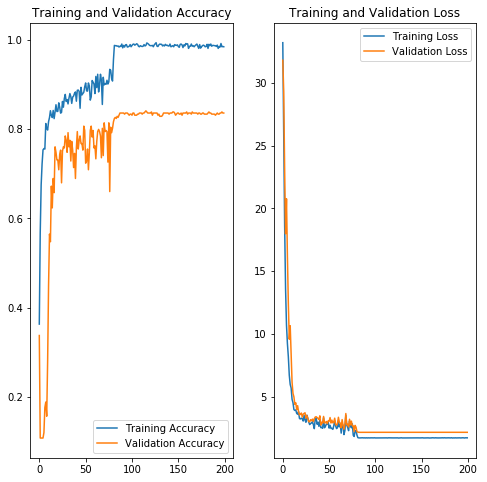

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict

In [4]:
model = keras.models.load_model('./model/Datagen다음normalfit25-0.8655-0.7600.hdf5')

In [5]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3


In [6]:
submission.to_csv('08281008(Datagen다음normalfit25-0.8655-0.7600).csv', index=False)